This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

In [10]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import metpy
import requests
import matplotlib.pyplot as pl
import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from metpy.plots import ctables
from osgeo import osr
from wradlib.io.xarray import CfRadial, OdimH5
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

from datetime import timedelta, datetime

import urllib
import io
import glob

try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

from html.parser import HTMLParser
try:
    import urlparse
    from urllib import urlencode
except: # For Python 3
    import urllib.parse as urlparse
    from urllib.parse import urlencode

def ceil_dt(dt, delta):
    return dt + (datetime.min - dt) % delta
    
now = datetime.utcnow()-timedelta(hours=0, minutes=15)
timenow_iso = now.strftime("%Y-%m-%dT%H:%M:00")

print(timenow_iso)
print(ceil_dt(now, timedelta(minutes=30)))

#f = glob.glob('/home/lmathias/wradlib/wradlib-notebooks/notebooks/OPERA/20200803123000_MAXIMUM_REFLECTIVITY.HDF5')
#f=f[-1]

#url = "https://geoservices.meteofrance.fr/services/odyssey?product=MAXIMUM_REFLECTIVITY"
#params = {'time': timenow_iso+'Z','token':'__0FJkG68Nupy4ioUVcbSFMLTpJbsX7zixwHzoQrAi688__', 'format': 'HDF5'}

#url_parts = list(urlparse.urlparse(url))
#query = dict(urlparse.parse_qsl(url_parts[4]))
#query.update(params)

#url_parts[4] = urlencode(query).replace("%3A", ":")
#url = urlparse.urlunparse(url_parts)


#print(url)

#f = requests.get(url)

#open('/home/lmathias/wradlib/wradlib-notebooks/notebooks/OPERA/maxdbz_latest.hdf5', 'wb').write(f.content)

f = glob.glob('/home/lmathias/wradlib/wradlib-notebooks/notebooks/OPERA/20160722/ODC.REF_201607221830.h5')
f=f[-1]
print(f)

vol = wrl.io.hdf.read_opera_hdf5(f)

#print(vol)
import dateutil.parser
date = vol['dataset1/what']['enddate'].decode("utf-8")
print(date)
time = vol['dataset1/what']['endtime'].decode("utf-8")
print(time)
time = date+time
print(time)
time2 = datetime.strptime(time, "%Y%m%d%H%M%S")-timedelta(hours=0, minutes=5)
print(time2)

2021-04-12T14:08:00
2021-04-12 14:30:00
/home/lmathias/wradlib/wradlib-notebooks/notebooks/OPERA/20160722/ODC.REF_201607221830.h5
20160722
183500
20160722183500
2016-07-22 18:30:00


PROJCS["unknown",
    GEOGCS["unknown",
        DATUM["Unknown based on WGS84 ellipsoid",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",55],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",1950000],
    PARAMETER["false_northing",-2100000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]
opera_maxdbz_201607221800.jpeg


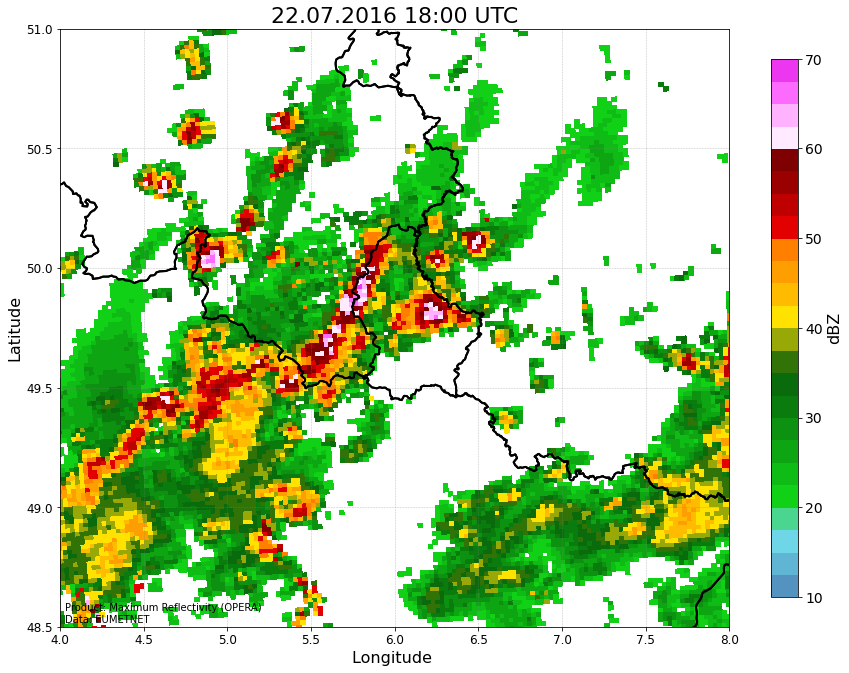

In [31]:
from pyproj import Proj,transform
import numpy.ma as ma


myProj = Proj("+proj=laea +lat_0=55.0 +lon_0=10.0 +x_0=1950000.0 +y_0=-2100000.0 +units=m +ellps=WGS84")
projdef = "+proj=laea +lat_0=55.0 +lon_0=10.0 +x_0=1950000.0 +y_0=-2100000.0 +units=m +ellps=WGS84"
proj_stereo = wrl.georef.proj4_to_osr(projdef)
print(proj_stereo)

 
opera_proj = Proj(projparams=projdef)  
wgs_proj = Proj(init='EPSG:4326')  # WGS84

LL_lon = vol['where']['LL_lon']
UL_lon = vol['where']['UL_lon']
UR_lon = vol['where']['UR_lon']
LR_lon = vol['where']['LR_lon']
LL_lat = vol['where']['LL_lat']
UL_lat = vol['where']['UL_lat']
UR_lat = vol['where']['UR_lat']
LR_lat = vol['where']['LR_lat']

x0, y0 = transform(wgs_proj, opera_proj, UL_lon, UL_lat)
x1, y1 = transform(wgs_proj, opera_proj, LR_lon, LR_lat)

xscale = 2000.0 
yscale = 2000.0

x = np.linspace(x0, x1, 1900)
y = np.linspace(y0, y1, 2200)
xv, yv = np.meshgrid(x, y)

lon, lat = transform(opera_proj, wgs_proj, xv, yv)

def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename2 = wrl.util.get_wradlib_data_file('geo/gadm36_ITA_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_GBR_0.shp')
    filename7 = wrl.util.get_wradlib_data_file('geo/gadm36_NLD_0.shp')
    filename8 = wrl.util.get_wradlib_data_file('geo/gadm36_ESP_0.shp')
    filename9 = wrl.util.get_wradlib_data_file('geo/gadm36_CZE_0.shp')
    filename10 = wrl.util.get_wradlib_data_file('geo/gadm36_CHE_0.shp')
    filename11 = wrl.util.get_wradlib_data_file('geo/gadm36_DNK_0.shp')
    filename12 = wrl.util.get_wradlib_data_file('geo/gadm36_AUT_0.shp')
    filename13 = wrl.util.get_wradlib_data_file('geo/gadm36_POL_0.shp')
    filename14 = wrl.util.get_wradlib_data_file('geo/gadm36_SVN_0.shp')
    filename15 = wrl.util.get_wradlib_data_file('geo/gadm36_HRV_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset2, inLayer2 = wrl.io.open_vector(filename2)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    dataset7, inLayer7 = wrl.io.open_vector(filename7)
    dataset8, inLayer8 = wrl.io.open_vector(filename8)
    dataset9, inLayer9 = wrl.io.open_vector(filename9)
    dataset10, inLayer10 = wrl.io.open_vector(filename10)
    dataset11, inLayer11 = wrl.io.open_vector(filename11)
    dataset12, inLayer12 = wrl.io.open_vector(filename12)
    dataset13, inLayer13 = wrl.io.open_vector(filename13)
    dataset14, inLayer14 = wrl.io.open_vector(filename14)
    dataset15, inLayer15 = wrl.io.open_vector(filename15)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer)
    borders2, keys2 = wrl.georef.get_vector_coordinates(inLayer2)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6)
    borders7, keys7 = wrl.georef.get_vector_coordinates(inLayer7)
    borders8, keys8 = wrl.georef.get_vector_coordinates(inLayer8)
    borders9, keys9 = wrl.georef.get_vector_coordinates(inLayer9)
    borders10, keys10 = wrl.georef.get_vector_coordinates(inLayer10)
    borders11, keys11 = wrl.georef.get_vector_coordinates(inLayer11)
    borders12, keys12 = wrl.georef.get_vector_coordinates(inLayer12)
    borders13, keys13 = wrl.georef.get_vector_coordinates(inLayer13)
    borders14, keys14 = wrl.georef.get_vector_coordinates(inLayer14)
    borders15, keys15 = wrl.georef.get_vector_coordinates(inLayer15)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders2, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders6, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders7, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders8, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders9, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders10, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders11, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders12, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders13, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders14, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders15, color='black', lw=2, zorder=4)



cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')

newcmap = ListedColormap(cmap(np.linspace(0.34, 0.92, 24)))

maxdbz = vol['dataset1/data1/data']

maxdbz = ma.masked_where(maxdbz < 20, maxdbz)

#maxdbz_int = griddata(lon,lat, maxdbz, method='linear')

fig = pl.figure(figsize=(15,11))
ax = pl.subplot(111)
pm = ax.pcolormesh(lon, lat, maxdbz, cmap=newcmap, vmin=10, vmax=70)
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[0,10,20,30,40,50,60,70],orientation='vertical')
cb.set_label("dBZ",fontsize=16)
cb.ax.tick_params(labelsize=14)
pl.xlabel("Longitude ",fontsize=16) 
pl.ylabel("Latitude",fontsize=16)
pl.title(time2.strftime("%d.%m.%Y %H:%M UTC"),fontsize=22)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
pl.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
pl.xlim(4, 8)
pl.ylim(48.5, 51)
plot_borders2(ax)
pl.gcf().text(0.13, 0.145, 'Product: Maximum Reflectivity (OPERA)', fontsize=10)
pl.gcf().text(0.13, 0.13, 'Data: EUMETNET', fontsize=10)

base_filename='opera_maxdbz_'
suffix='.jpeg'
my_file = base_filename+time2.strftime("%Y%m%d%H%M")+suffix
print(my_file)
#pl.savefig(my_file, bbox_inches='tight', dpi=150)
pl.savefig("test_maxdbz.png", bbox_inches='tight', dpi=150)

In [25]:
f = glob.glob('/home/lmathias/wradlib/wradlib-notebooks/notebooks/OPERA/20160722/ODC.RRT_201607221800.h5')
f=f[-1]
print(f)

vol2 = wrl.io.hdf.read_opera_hdf5(f)

print(vol2)
import dateutil.parser
date = vol2['dataset1/what']['enddate'].decode("utf-8")
print(date)
time = vol2['dataset1/what']['endtime'].decode("utf-8")
print(time)
time = date+time
print(time)
time2 = datetime.strptime(time, "%Y%m%d%H%M%S")-timedelta(hours=0, minutes=5)
print(time2)
#time = time-timedelta(hours=0, minutes=5)

/home/lmathias/wradlib/wradlib-notebooks/notebooks/OPERA/20160722/ODC.RRT_201607221800.h5
{'dataset1/data1/data': array([[-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.],
       [-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.],
       [-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.],
       ...,
       [-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.],
       [-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.],
       [-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.]]), 'dataset1/what': {'enddate': b'20160722', 'endtime': b'180500', 'gain': 1.0, 'nodata': -9999000.0, 'offset': 0.0, 'product': b'COMP', 'quantity': b'RATE', 'startdate': b'20160722', 'starttime': b'175000', 'undetect': -8888000.0}, 'dataset2/data1/data': array([[-9999000., -9999000., -9999000., ..., -9999000., -9999000.,
        -9999000.],
   

opera_sfcrr_201607221800.jpeg


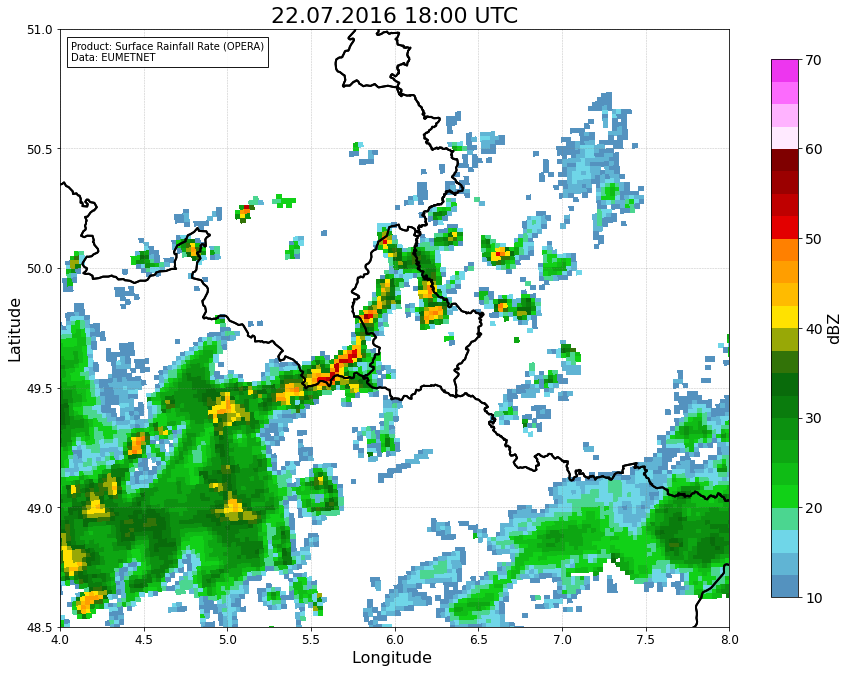

In [26]:
import matplotlib.colors as mcolors


cmap2 = ctables.colortables.get_colortable('NWSReflectivity')

sfcrr = vol2['dataset1/data1/data']
sfcdbz = 10*np.log10(200*sfcrr**(1.6))
sfcdbz = ma.masked_where(sfcdbz < 10, sfcdbz)
sfcrr = ma.masked_where(sfcrr < 0.5, sfcrr)

fig = pl.figure(figsize=(15,11))
ax = pl.subplot(111)
#pm = ax.pcolormesh(lon, lat, sfcrr, cmap=cmap2, norm=mcolors.PowerNorm(gamma=0.4), vmin=0.5, vmax=400)
#cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[1,3,7.5,15,26,41,60,84.5,111.5,145,185,230,280,340,400], orientation='vertical')
pm = ax.pcolormesh(lon, lat, sfcdbz, cmap=newcmap, vmin=10, vmax=70)
#cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[1,3,7.5,15,26,41,60,84.5,111.5,145,185,230,280,340,400], orientation='vertical')
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[0,10,20,30,40,50,60,70],orientation='vertical')
cb.set_label("dBZ",fontsize=16)
cb.ax.tick_params(labelsize=14)
pl.xlabel("Longitude ",fontsize=16) 
pl.ylabel("Latitude",fontsize=16)
pl.title(time2.strftime("%d.%m.%Y %H:%M UTC"),fontsize=22)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
pl.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
pl.xlim(4, 8)
pl.ylim(48.5, 51)
plot_borders2(ax)
t = pl.gcf().text(0.135, 0.84, 'Product: Surface Rainfall Rate (OPERA)\nData: EUMETNET', fontsize=10)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

base_filename='opera_sfcrr_'
suffix='.jpeg'
my_file = base_filename+time2.strftime("%Y%m%d%H%M")+suffix
print(my_file)
pl.savefig("test_sfcrr.png", bbox_inches='tight', dpi=150)